In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv(r"C:\Users\86135\Desktop\credit-overdue.csv")

In [3]:
data

,debt,income,overdue
0,1.86,4.39,0
1,0.42,4.91,0
2,2.07,1.06,1
3,0.64,1.55,0
4,1.24,2.48,0
...,...,...,...
145,1.66,1.59,1
146,1.75,3.86,0
147,2.08,0.22,1
148,1.56,4.85,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   debt     150 non-null    float64
 1   income   150 non-null    float64
 2   overdue  150 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 3.6 KB


通过info()函数可以看到并没有缺失值

([<matplotlib.patches.Wedge at 0x22a451053a0>,
 [Text(0.8018655028537539, 0.7530018030078657, '1'),
  Text(-0.8018655381043115, -0.7530017654698314, '0')])

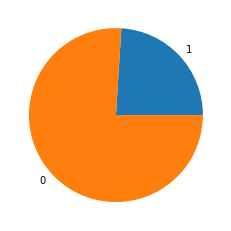

In [5]:
import matplotlib.pyplot as plt
plt.pie(x=[36,114],labels=['1','0'])

可以看到类别1与0数量相差其实很大，所以这是一个较为偏斜的数据，所以后续的评价标准会相应考虑到类别的偏斜

In [6]:
data=np.array(data)
X=data[:,0:2]

使用numpy的array包一下pandas的dataframe便于后续的矩阵运算

In [7]:
y=data[:,2]

In [8]:
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=3)
poly.fit(X)
X=poly.transform(X)

增加多项式特征，并设置最高次数为3，这样会出现x1x2,x1方,x2方，x1三次方，x2三次方，x1方x2,x2方x1,这七个新的多项式特征，在提升数据复杂度的同时也提升了数据的信息量，从而使得线性模型对非线性特征有了更好的适应性（特征衍生）

In [ ]:
debt = data['debt'].values
income = data['income'].values
overdue = data['overdue'].values
plt.scatter(x=debt, y=income, c=overdue)

In [9]:
X.shape

(150, 10)

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.3,random_state=233)

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
std=StandardScaler()
std.fit(X_train,y_train)
X_train_std=std.transform(X_train)
X_test_std=std.transform(X_test)

均值方差归一化：将每个特征的数据映射到标准正态分布上，映射之后每个数据的影响力不受数据的数量级影响，在对距离敏感的算法中归一化十分重要

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [14]:
params= {
    'C':list(np.linspace(0.05,1,19)),
    'solver':['liblinear','sag','newton-cg','lbfgs']}
log_reg = LogisticRegression(penalty='l2',max_iter=10000)
log_reg_grid = GridSearchCV(log_reg,params,cv=5,n_jobs=-1,scoring='f1_weighted')#而weighted-F1则根据每一类的比例分别赋予不同的权重。
log_reg_grid.fit(X_train_std,y_train)
y_predict=log_reg_grid.predict(X_test_std)
#输出最优参数
log_reg_grid.best_score_#打印最高分

0.9813526570048309

使用网格搜索传入逻辑回归分类器自动调参，c表示正则化系数，默认值为1，越小表示正则化越强，penalty为惩罚项默认为l2。用于指定惩罚项中使用的规范。newton-cg、sag和lbfgs求解算法只支持L2规范，所以我们只在l2的基础上进行solver的最佳参数的搜索，防止冲突，solver是优化算法选择参数，我们将与l2惩罚项匹配的所有solver参数传入搜索最佳参数

接下来我们传入参数表与逻辑回归分类器，并搜索使得f1_weighted分数最大的最优参数，f1_weighted分数根据每一类的比例赋予不同的权重使得对类别不平衡的样本具有更好的拟合能力

In [15]:
log_reg_grid.best_params_#打印最优参数

{'C': 0.525, 'solver': 'liblinear'}

In [16]:
from sklearn.metrics import f1_score
f1_score(y_test,y_predict)

0.9411764705882353

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        29
         1.0       1.00      0.89      0.94         9

    accuracy                           0.97        38
   macro avg       0.98      0.94      0.96        38
weighted avg       0.97      0.97      0.97        38



Text(33.0, 0.5, 'true')

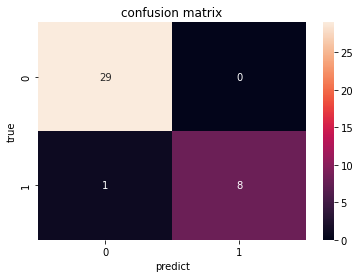

In [18]:

log_confusion=confusion_matrix(y_test,y_predict)
import seaborn as sn
ax = sn.heatmap(log_confusion,annot=True,fmt='.20g')
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴

In [ ]:
x1_plot = np.arange(1, 3, step=0.1)
x2_plot = -(x1_plot * log_reg.coef_[0][0] + log_reg.intercept_)
plt.plot(x1_plot, x2_plot)